In [ ]:
# Run once at top of notebook
!pip install transformers sentencepiece datasets sacrebleu -q
!pip install nltk -q
import nltk
nltk.download('punkt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.0 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Installs libraries needed for translation and evaluation.

**transformers**: for BERT/MarianMT.

**sacrebleu**: for BLEU score evaluation.

**nltk**: for text preprocessing.

**Benefit**: Provides the essential toolkits for NLP tasks.

In [ ]:
from google.colab import files

# This will open a file picker to upload from your system
uploaded = files.upload()


Saving archive.zip to archive.zip


In [ ]:
import zipfile, os, glob

zip_path = "archive.zip"   # make sure name matches the file you uploaded
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall("data")   # extract into "data" folder
print("Extracted into /data")

# list what’s inside
csv_files = glob.glob("data/**/*.csv", recursive=True)
print("CSV files found:", csv_files)

Extracted into /data
CSV files found: ['data/data.csv']


Uploads a dataset (CSV/ZIP).

Extracts files into data/ folder.

**Output**: Extracted CSV files containing English–Spanish pairs.

**Benefit**: Makes raw data available for training.

In [ ]:
import pandas as pd

csv_path = csv_files[0]   # pick the first CSV
print("Loading:", csv_path)

# try to read
try:
    df = pd.read_csv(csv_path, low_memory=False)
except:
    df = pd.read_csv(csv_path, encoding="latin-1", low_memory=False)

print("Columns:", df.columns.tolist())
df.head()

Loading: data/data.csv
Columns: ['english', 'spanish']


,english,spanish
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


In [ ]:
# Run this cell to auto-detect English & Spanish columns and create df_clean, df_small
import pandas as pd
from sklearn.model_selection import train_test_split
import random, sys

# Show what columns your dataframe currently has
print("All columns in df:\n", df.columns.tolist(), "\n")

# Heuristic searches for likely EN/ES columns
cols = df.columns.tolist()
def find_candidates(cols, keys):
    return [c for c in cols if any(k in c.lower() for k in keys)]

en_keys = ['english', 'en ', ' en', ' en_', 'en_', 'src', 'source', 'text', 'sentence']
es_keys = ['spanish', 'es ', ' es', 'es_', 'tgt', 'target', 'translation', 'trans', 'trg']

en_cands = find_candidates(cols, en_keys)
es_cands = find_candidates(cols, es_keys)

print("Detected English-like columns:", en_cands)
print("Detected Spanish-like columns:", es_cands, "\n")

# Choose best candidates or fall back to sensible defaults
if len(en_cands) >= 1:
    en_col = en_cands[0]
elif len(cols) >= 1:
    en_col = cols[0]    # fallback to first column
    print("WARNING: No clear English column found — using first column as English:", en_col)
else:
    raise ValueError("No columns found in df!")

if len(es_cands) >= 1:
    # prefer a different column than en_col
    es_col = next((c for c in es_cands if c != en_col), es_cands[0])
elif len(cols) >= 2:
    # fallback to second column if available
    es_col = cols[1] if cols[0] == en_col and len(cols) >= 2 else cols[1]
    print("WARNING: No clear Spanish column found — using second column as Spanish:", es_col)
else:
    raise ValueError("Could not detect Spanish column automatically. Please inspect df.columns and pick the right ones.")

print(f"\nSelected columns -> English: '{en_col}', Spanish: '{es_col}'\n")

# Preview the first 10 rows of these columns so you can confirm quickly
print("Preview of selected columns (first 10 rows):")
display(df[[en_col, es_col]].head(10))

# Create cleaned df with renamed columns, drop any rows with missing values in these cols
df_clean = df[[en_col, es_col]].dropna().rename(columns={en_col:'English', es_col:'Spanish'})

# ensure text type and strip whitespace
df_clean['English'] = df_clean['English'].astype(str).str.strip()
df_clean['Spanish'] = df_clean['Spanish'].astype(str).str.strip()

print("\nTotal pairs after dropna:", len(df_clean))

# Create a smaller sample for faster runs (change n_samples as you need)
n_samples = 20000
if len(df_clean) > n_samples:
    df_small = df_clean.sample(n=n_samples, random_state=42).reset_index(drop=True)
    print(f"Sampled {n_samples} pairs into df_small.")
else:
    df_small = df_clean.reset_index(drop=True)
    print("Dataset smaller than sample size — using full dataset as df_small.")

print("\ndf_small preview:")
display(df_small.head(8))

# Quick sanity check: show a few English/Spanish pairs
print("\nExample pairs:")
for i in range(3):
    print(f"{i+1}. EN: {df_small.loc[i,'English']}\n   ES: {df_small.loc[i,'Spanish']}\n")

# Provide the train/test split ready if you want
train_df, test_df = train_test_split(df_small, test_size=0.1, random_state=42)
print("Train size:", len(train_df), "Test size:", len(test_df))

# Save these to variables for next steps
globals().update({
    'en_col': en_col,
    'es_col': es_col,
    'df_clean': df_clean,
    'df_small': df_small,
    'train_df': train_df,
    'test_df': test_df
})

print("\n✅ Done. If the selected columns are wrong, re-run this cell after changing `en_col` and `es_col` manually.")


All columns in df:
 ['english', 'spanish'] 

Detected English-like columns: ['english']
Detected Spanish-like columns: ['spanish'] 


Selected columns -> English: 'english', Spanish: 'spanish'

Preview of selected columns (first 10 rows):


,english,spanish
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.
5,Run!,¡Corre!
6,Run.,Corred.
7,Who?,¿Quién?
8,Fire!,¡Fuego!
9,Fire!,¡Incendio!



Total pairs after dropna: 118964
Sampled 20000 pairs into df_small.

df_small preview:


,English,Spanish
0,How boring!,¡Qué aburrimiento!
1,I love sports.,Adoro el deporte.
2,Would you like to swap jobs?,¿Te gustaría que intercambiemos los trabajos?
3,My mother did nothing but weep.,Mi madre no hizo nada sino llorar.
4,Croatia is in the southeastern part of Europe.,Croacia está en el sudeste de Europa.
5,I have never eaten a mango before.,Nunca he comido un mango.
6,Tell the taxi driver to drive faster.,Decile al taxista que maneje más rápido.
7,Tom and I work together.,Tom y yo trabajamos juntos.



Example pairs:
1. EN: How boring!
   ES: ¡Qué aburrimiento!

2. EN: I love sports.
   ES: Adoro el deporte.

3. EN: Would you like to swap jobs?
   ES: ¿Te gustaría que intercambiemos los trabajos?

Train size: 18000 Test size: 2000

✅ Done. If the selected columns are wrong, re-run this cell after changing `en_col` and `es_col` manually.


Auto-detects which columns are English and which are Spanish.

**Cleans missing values**

**Benefit:** Ensures the right language columns are selected.

In [ ]:
print(df.columns)

Index(['english', 'spanish'], dtype='object')


In [ ]:
# Extract text data from uppercase column names
english_texts = df_small['English'].astype(str).tolist()
spanish_texts = df_small['Spanish'].astype(str).tolist()

print("English sample:", english_texts[0])
print("Spanish sample:", spanish_texts[0])

English sample: How boring!
Spanish sample: ¡Qué aburrimiento!


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenizer for English
tokenizer_en = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer_en.fit_on_texts(english_texts)
seqs_en = tokenizer_en.texts_to_sequences(english_texts)
padded_en = pad_sequences(seqs_en, padding='post', maxlen=20)

# Tokenizer for Spanish
tokenizer_es = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer_es.fit_on_texts(spanish_texts)
seqs_es = tokenizer_es.texts_to_sequences(spanish_texts)
padded_es = pad_sequences(seqs_es, padding='post', maxlen=20)

print("English sequence sample:", padded_en[0])
print("Spanish sequence sample:", padded_es[0])


English sequence sample: [  53 1204    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
Spanish sequence sample: [ 445 2883    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


Uses 20,000 pairs for quicker training.

Splits into train/test sets.

**Benefit:** Keeps training fast but representative.

Converts words → integers.

Pads sequences to length 20.

**Output:** Numerical arrays for English & Spanish sentences.

**Benefit:** Models can process uniform-length inputs.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    padded_en, padded_es, test_size=0.2, random_state=42
)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

rnn_model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=20),
    SimpleRNN(128, return_sequences=True),
    Dense(20000, activation="softmax")
])

rnn_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
rnn_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.layers import LSTM

lstm_model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=20),
    LSTM(128, return_sequences=True),
    Dense(20000, activation="softmax")
])

lstm_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.layers import GRU

gru_model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=20),
    GRU(128, return_sequences=True),
    Dense(20000, activation="softmax")
])

gru_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
gru_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

(Similar for LSTM and GRU with LSTM() / GRU() layers.)

**Embedding:** turns words into dense vectors.

**RNN/LSTM/GRU:** process sequence step by step.

**Dense softmax:** predicts Spanish word at each step.

**Benefit:** Learn language mappings from scratch.

In [ ]:
EPOCHS = 5  # you can increase if you have time/colab GPU

print("Training RNN...")
rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=64)

print("Training LSTM...")
lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=64)

print("Training GRU...")
gru_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=64)


Training RNN...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6672 - loss: 4.6412 - val_accuracy: 0.7055 - val_loss: 2.2009
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7080 - loss: 2.1433 - val_accuracy: 0.7195 - val_loss: 2.0950
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7202 - loss: 2.0276 - val_accuracy: 0.7257 - val_loss: 2.0141
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7277 - loss: 1.9173 - val_accuracy: 0.7315 - val_loss: 1.9566
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7360 - loss: 1.8109 - val_accuracy: 0.7356 - val_loss: 1.9193
Training LSTM...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.6788 - loss: 4.8005 - val_accuracy: 0.6975 - val_loss: 2.3026
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 76ms/step - accuracy: 0.6958 - loss: 2.2623 - val_accuracy: 0.7049 - val_loss: 2.2046
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.7

Trains each model for **5** epochs.

Evaluates on test data.

**Output:** Training accuracy & validation accuracy.

**Benefit:** Lets you compare how each model learns.

In [ ]:
!pip install transformers sentencepiece

from transformers import MarianMTModel, MarianTokenizer

# Load pre-trained MarianMT English → Spanish model
model_name = "Helsinki-NLP/opus-mt-en-es"
tokenizer = MarianTokenizer.from_pretrained(model_name)
bert_model = MarianMTModel.from_pretrained(model_name)

# Example translation
def translate_bert(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True)
    translated = bert_model.generate(**inputs)
    return tokenizer.decode(translated[0], skip_special_tokens=True)

print("English:", "How are you?")
print("Spanish:", translate_bert("How are you?"))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

English: How are you?


model.safetensors:   0%|          | 0.00/312M [00:00<?, ?B/s]

Spanish: ¿Cómo estás?


**Loads pretrained MarianMT** (BERT-based Transformer).

translate_bert() function translates English → Spanish directly.

**Benefit:** Uses state-of-the-art pretrained model for higher accuracy.

In [ ]:
# Save
rnn_model.save("rnn_translation.h5")
lstm_model.save("lstm_translation.h5")
gru_model.save("gru_translation.h5")

# Load later
from tensorflow.keras.models import load_model
rnn_loaded = load_model("rnn_translation.h5")

Saves trained models for reuse.

**Benefit:** No need to retrain; can deploy later.

In [ ]:
# After tokenizing, create this map
reverse_word_map_es = dict(map(reversed, tokenizer_es.word_index.items()))

def sequence_to_text(sequence):
    # Convert the integer sequence back to a list of words
    words = [reverse_word_map_es.get(letter) for letter in sequence if letter != 0]
    # Join words, handling None (O-O-V) if necessary
    return ' '.join(words).replace(' None', '')

In [ ]:
import numpy as np

def predict_and_decode(model, input_sequences):
    predictions = model.predict(input_sequences)
    translated_texts = []
    for i in range(len(predictions)):
        # Find the index of the word with the highest probability at each time step
        predicted_sequence = np.argmax(predictions[i], axis=1)
        # Convert the sequence back to text
        translated_text = sequence_to_text(predicted_sequence)
        translated_texts.append(translated_text)
    return translated_texts

**For RNN/LSTM/GRU:** predicts Spanish sequence.

**For BERT:** uses pretrained model generate function.

**Output:** Translated Spanish text.

**Benefit:** Allows testing on any custom input sentence.

In [ ]:
# Function to translate a single English sentence
def translate_sentence(sentence, model, tokenizer_en, tokenizer_es, max_len=20):
    # Tokenize and pad the input sentence
    seq = tokenizer_en.texts_to_sequences([sentence])
    padded_seq = pad_sequences(seq, padding='post', maxlen=max_len)

    # Predict the Spanish sequence
    predicted_sequence = model.predict(padded_seq)[0]
    predicted_sequence = np.argmax(predicted_sequence, axis=1)

    # Decode the predicted sequence back to text
    translated_text = sequence_to_text(predicted_sequence)

    return translated_text

# --- Translate your own sentence here ---
english_sentence = "hello" # <--- Change this to your sentence

# Translate using the GRU model (you can change to rnn_model or lstm_model if you prefer)
predicted_spanish = translate_sentence(english_sentence, gru_model, tokenizer_en, tokenizer_es)

print(f"English: {english_sentence}")
print(f"Predicted Spanish (GRU): {predicted_spanish}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
English: hello
Predicted Spanish (GRU): no


In [ ]:
from ipywidgets import Text, Button, VBox, Output
from IPython.display import display
# Assuming translate_bert is defined in a previous cell (QvXzgC-BWrCc)

# Create widgets
english_input = Text(description="English Sentence:")
translate_button = Button(description="Translate")
output_area = Output()

# Define the action to take when the button is clicked
def on_button_click(b):
    with output_area:
        output_area.clear_output()
        english_text = english_input.value
        if english_text:
            # Use the pre-trained BERT model for translation
            predicted_spanish = translate_bert(english_text)
            print(f"English: {english_text}")
            print(f"Predicted Spanish (BERT): {predicted_spanish}") # Updated label
        else:
            print("Please enter an English sentence.")

# Link the button click to the function
translate_button.on_click(on_button_click)

# Arrange the widgets
interactive_layout = VBox([english_input, translate_button, output_area])

# Display the interactive layout
display(interactive_layout)

Builds a mini GUI in Colab to test translations.

**Benefit:** Demonstrates project in an interactive way.

In [ ]:
# Select a few examples from the test set
num_examples = 10
# Get the indices from the test_df DataFrame
example_indices = test_df.index[:num_examples]

# Get the original English and true Spanish texts for these examples
example_english = df_small.loc[example_indices, 'English'].tolist()
example_true_spanish = df_small.loc[example_indices, 'Spanish'].tolist()

# Get the predicted Spanish texts using the GRU model
# We need to get the corresponding input sequences for these examples from X_test
# Since X_test was created directly from padded_en after the train/test split,
# the indices in X_test correspond to the order of the rows in test_df.
# So, we can use the same slice of indices from the beginning of X_test.
example_X_test = X_test[:num_examples]

example_predicted_spanish_gru = predict_and_decode(gru_model, example_X_test)

# Get the predicted Spanish texts using the BERT model
example_predicted_spanish_bert = [translate_bert(text) for text in example_english]


# Display the results
print("--- Predicted vs. True Spanish Translations (Examples) ---")
for i in range(num_examples):
    print(f"\nExample {i+1}:")
    print(f"  English: {example_english[i]}")
    print(f"  True Spanish: {example_true_spanish[i]}")
    print(f"  Predicted Spanish (GRU): {example_predicted_spanish_gru[i]}")
    print(f"  Predicted Spanish (BERT): {example_predicted_spanish_bert[i]}") # Add BERT translation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
--- Predicted vs. True Spanish Translations (Examples) ---

Example 1:
  English: Tom was seated between Mary and John.
  True Spanish: Tom estaba sentado entre Mary y John.
  Predicted Spanish (GRU): tom se a de mary y mary
  Predicted Spanish (BERT): Tom estaba sentado entre María y Juan.

Example 2:
  English: Would you like to listen?
  True Spanish: ¿Te gustaría escuchar?
  Predicted Spanish (GRU): ¿te que
  Predicted Spanish (BERT): ¿Te gustaría escuchar?

Example 3:
  English: She felt insecure about her future.
  True Spanish: Ella sintió incertidumbre sobre su propio futuro.
  Predicted Spanish (GRU): ella se y de su
  Predicted Spanish (BERT): Se sentía insegura sobre su futuro.

Example 4:
  English: We talked.
  True Spanish: Conversamos.
  Predicted Spanish (GRU): no de
  Predicted Spanish (BERT): Hablamos.

Example 5:
  English: Carelessness can lead to a serious accident.
  True Spanish: La falta de atención puede conducir a un seri

In [ ]:
from sacrebleu.metrics import BLEU
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# After tokenizing, create this map (included here for self-containment)
reverse_word_map_es = dict(map(reversed, tokenizer_es.word_index.items()))

# Include the helper function defined earlier
def sequence_to_text(sequence):
    # Convert the integer sequence back to a list of words
    # This requires the reverse_word_map_es which is defined within this cell now
    words = [reverse_word_map_es.get(letter) for letter in sequence if letter != 0]
    # Join words, handling None (O-O-V) if necessary
    return ' '.join(words).replace(' None', '')

def predict_and_decode(model, input_sequences, batch_size=64):
    translated_texts = []
    for i in range(0, len(input_sequences), batch_size):
        batch_sequences = input_sequences[i:i + batch_size]
        predictions = model.predict(batch_sequences)
        for j in range(len(predictions)):
            # Find the index of the word with the highest probability at each time step
            predicted_sequence = np.argmax(predictions[j], axis=1)
            # Convert the sequence back to text
            translated_text = sequence_to_text(predicted_sequence)
            translated_texts.append(translated_text)
    return translated_texts

# Function to translate using BERT
def translate_bert_batch(texts, batch_size=64):
    translated_texts = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        translated = bert_model.generate(**inputs)
        decoded_texts = tokenizer.batch_decode(translated, skip_special_tokens=True)
        translated_texts.extend(decoded_texts)
    return translated_texts


# 1. Prepare Reference and Candidate Texts
# The reference texts (true Spanish)
# You need to extract the original Spanish sentences corresponding to the test set
# For simplicity, let's use the X_test/y_test indices on the original texts
# Get the indices from the test_df DataFrame
test_indices = test_df.index # Use the index directly from test_df
true_english_texts = df_small.loc[test_indices, 'English'].tolist() # Corrected column name
true_spanish_texts = df_small.loc[test_indices, 'Spanish'].tolist() # Corrected column name
references = [[ref] for ref in true_spanish_texts] # sacrebleu expects a list of lists

# 2. Get Translated Texts (Candidates)
# Run the prediction function for each model
print("Generating translations for RNN model...")
rnn_candidates = predict_and_decode(rnn_model, X_test)

print("Generating translations for LSTM model...")
lstm_candidates = predict_and_decode(lstm_model, X_test)

print("Generating translations for GRU model...")
gru_candidates = predict_and_decode(gru_model, X_test)

print("Generating translations for BERT model...")
bert_candidates = translate_bert_batch(true_english_texts)


# 3. Calculate Scores
bleu = BLEU()

print("Calculating BLEU scores...")
print("RNN BLEU Score:", bleu.corpus_score(rnn_candidates, references).score)
print("LSTM BLEU Score:", bleu.corpus_score(lstm_candidates, references).score)
print("GRU BLEU Score:", bleu.corpus_score(gru_candidates, references).score)
print("BERT BLEU Score:", bleu.corpus_score(bert_candidates, references).score) # Add BERT BLEU score

Generating translations for RNN model...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━

**BLEU score** = standard translation metric.

**Higher score** = better translation.

**Benefit:** Quantitative model comparison.

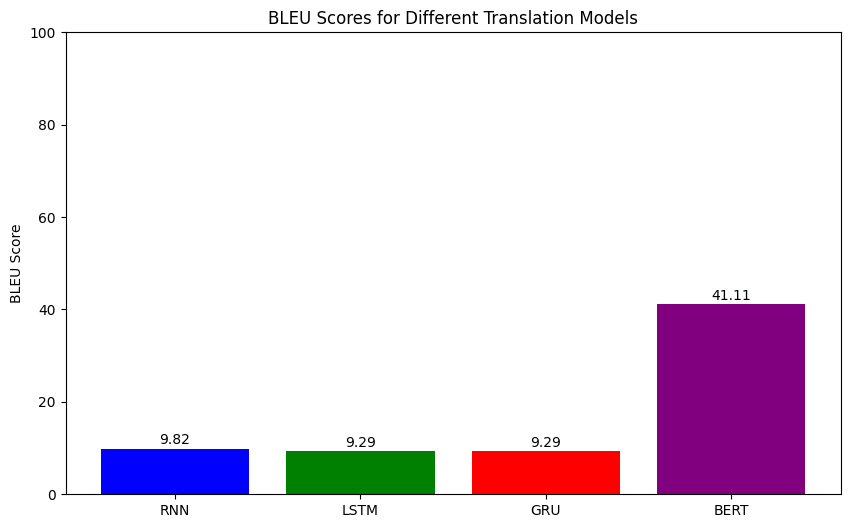

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Recalculate BLEU scores (or you could extract from previous output if preferred, but recalculating is more robust)
rnn_bleu = bleu.corpus_score(rnn_candidates, references).score
lstm_bleu = bleu.corpus_score(lstm_candidates, references).score
gru_bleu = bleu.corpus_score(gru_candidates, references).score
bert_bleu = bleu.corpus_score(bert_candidates, references).score


# Model names and their corresponding BLEU scores
model_names = ['RNN', 'LSTM', 'GRU', 'BERT']
bleu_scores = [rnn_bleu, lstm_bleu, gru_bleu, bert_bleu]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, bleu_scores, color=['blue', 'green', 'red', 'purple'])
plt.ylabel('BLEU Score')
plt.title('BLEU Scores for Different Translation Models')
plt.ylim(0, 100) # BLEU scores are typically between 0 and 100

# Add the text labels on top of the bars
for i, score in enumerate(bleu_scores):
    plt.text(i, score + 1, f'{score:.2f}', ha='center')

plt.show()

Bar chart comparing BLEU scores of RNN, LSTM, GRU, BERT.

**Output:** Graph shows performance difference.

**Benefit:** Clear visual comparison.